In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gdown

## Load data

- There is no need to running the code blocks below to run preprocessing. The *final* prepocessed file will be downloaded from the google drive and used further down.
- However you can download the orginal csv from the google drive below and run the preprocessing:

In [ ]:
def download_from_drive(drive_link, file_name):
    data_folder = Path('../../data/raw')
    data_file = data_folder / file_name

    # Final output has been downloaded
    if data_file.exists():
        print(f'{file_name} exists. Skipping download.')
        return
    
    # Download the file
    print(f'Downloading {file_name}...')
    data_folder.mkdir(parents=True, exist_ok=True)
    gdown.download(f"https://drive.google.com/uc?id={drive_link}", str(data_file), quiet=False)
    return data_file

reviews_file_name = 'org_steam_reviews.csv'

# Download the final data files - progress bar will appear
download_from_drive('16UqKhKuYI2kCrWyUmq4iXc3rYhcKMDZP', reviews_file_name)

# Load the data
df = pd.read_csv(f'../../data/raw/{reviews_file_name}')
df.head()


df_unfiltered = pd.read_csv(f'../../data/raw/{reviews_file_name}')
df_unfiltered.head()

org_steam_reviews.csv exists. Skipping download.


,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
0,NaN,2017-12-17,False,NaN,0.1,1,0,725280,41.0,This would not be acceptable as an entertainme...,NaN,Chaos Syren
1,NaN,2017-12-27,False,NaN,51.1,1,0,328100,769.0,looks like a facebook game,NaN,₮ʜᴇ Wᴀʀᴛᴏɴ
2,Product received for free,2017-10-16,False,2.0,14.6,1,1,328100,2.0,Better than Minecraft,NaN,hello?<
3,NaN,2018-01-04,False,NaN,5.0,1,0,35140,64.0,I love and idolized Batman and this game is Ma...,NaN,Cyderine916
4,NaN,2018-01-04,False,NaN,16.6,1,1,35140,577.0,Still worth playing in 2018.Probably my favori...,7.656120e+16,DarklyThinking


In [9]:
print(df.isnull().sum())

compensation    7598810
date                  1
early_access          0
found_funny     6552914
hours             26349
page                  0
page_order            0
product_id            0
products          14906
text                279
user_id         4582797
username            302
dtype: int64


In [15]:
# Fix missing values

# Remove reviews with missing text
df = df.dropna(subset=['text'])

# Remove the compensation column - too many missing values
df = df.drop(columns=['compensation'])

# Remove the 1 review with a missing date
df = df.dropna(subset=['date'])

# Remove the found_funny column
df = df.drop(columns=['found_funny'])

# If the hours column is missing, assume 0 hours played
df['hours'] = df['hours'].fillna(0)

# The user_id is widely missing, so we will rather use the usernames
# We will remove the user_id column and remove rows with missing usernames
df = df.drop(columns=['user_id'])

# Remove rows with missing usernames
df = df.dropna(subset=['username'])

# The products column is not needed to just remove it
df = df.drop(columns=['products'])

print(df.isnull().sum())

df.head()

date            0
early_access    0
hours           0
page            0
page_order      0
product_id      0
text            0
username        0
dtype: int64


,date,early_access,hours,page,page_order,product_id,text,username
0,2017-12-17,False,0.1,1,0,725280,This would not be acceptable as an entertainme...,Chaos Syren
1,2017-12-27,False,51.1,1,0,328100,looks like a facebook game,₮ʜᴇ Wᴀʀᴛᴏɴ
2,2017-10-16,False,14.6,1,1,328100,Better than Minecraft,hello?<
3,2018-01-04,False,5.0,1,0,35140,I love and idolized Batman and this game is Ma...,Cyderine916
4,2018-01-04,False,16.6,1,1,35140,Still worth playing in 2018.Probably my favori...,DarklyThinking


In [16]:
# Filter data

# Users may have reviewed the same game multiple times so we will use the latest review:
df = df.sort_values(by=['username', 'product_id', 'date'], ascending=[True, True, False])
df = df.drop_duplicates(subset=['username', 'product_id'])

duplicates = df.duplicated(subset=['username', 'product_id']).sum()
print(f"Number of duplicate (username, product_id) pairs: {duplicates}")

df_games = pd.read_csv("../../data/final/steam_games_final.csv")

# Total reviews
print(f"Total reviews: {len(df)}")
# Total users
active_users = df['username'].value_counts()
print(f"Total users from reviews: {len(active_users)}")

# Total games
active_games = df['product_id'].value_counts()
print(f"Total games from reviews: {len(active_games)}")

# Total games in the games dataset
print(f"Total games in the games dataset: {len(df_games)}")

# Do data analysis on non filtered data
df_unfiltered = df.copy()

min_reviews = 10
min_games = 100

# To get more meaningful results, let us ensure that the user has at least the minimum number of reviews
# and the game has at least the minimum number of reviews

df = df[ df['username'].isin(active_users[active_users > min_reviews].index) &
                         df['product_id'].isin(active_games[active_games > min_games].index)]

print(f"Total reviews after filtering: {len(df)}")

# Ensure product_id in df is treated as integers
reviewed_game_ids = df['product_id'].astype(int).unique()

# Filter df_games to keep only games that are reviewed
df_games_with_reviews = df_games[df_games['id'].isin(reviewed_game_ids)]

# Now df_games_with_reviews contains only games with at least one review
print(f"Number of games with reviews: {len(df_games_with_reviews)}")

df.head()

Number of duplicate (username, product_id) pairs: 0
Total reviews: 6844013
Total users from reviews: 2554103
Total games from reviews: 15471
Total games in the games dataset: 29245
Total reviews after filtering: 2064103
Number of games with reviews: 4811


,date,early_access,hours,page,page_order,product_id,text,username
6858188,2017-08-09,False,40.9,610,7,49520,So yea Borderlands. Umm Borderlands is game th...,I Need Healing
6131897,2017-08-09,False,6.7,24,8,57690,Best city builder in the world ! Awesome sound...,I Need Healing
1661023,2017-08-09,False,9.2,237,9,211420,Just Preapare to Die..,I Need Healing
446434,2014-09-03,False,3.7,345,6,224600,Game is fine but :/ the glyph.... Just f*ck gl...,I Need Healing
7307179,2016-09-22,False,10.8,1235,7,227300,Just tunn on the radio and boom !,I Need Healing


In [ ]:
df = df.reset_index(drop=True)
df_unfiltered = df_unfiltered.reset_index(drop=True)

,date,early_access,hours,page,page_order,product_id,text,username
0,2017-08-09,False,40.9,610,7,49520,So yea Borderlands. Umm Borderlands is game th...,I Need Healing
1,2017-08-09,False,6.7,24,8,57690,Best city builder in the world ! Awesome sound...,I Need Healing
2,2017-08-09,False,9.2,237,9,211420,Just Preapare to Die..,I Need Healing
3,2014-09-03,False,3.7,345,6,224600,Game is fine but :/ the glyph.... Just f*ck gl...,I Need Healing
4,2016-09-22,False,10.8,1235,7,227300,Just tunn on the radio and boom !,I Need Healing


# Create Ratings

## Use sentiment analysis to create ratings from reviews:
1 - Negative Review

3 - Neutral Review

5 - Positive Review

In [18]:
# Perform Sentiment Analysis on review text, we need to give either positive, neutral or negative sentiment to each review
# We will use TextBlob library for this purpose
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 5 # Positive
    elif analysis.sentiment.polarity == 0:
        return 3 # Neutral
    else:
        return 1 # Negative

# Apply sentiment analysis to each review to create a sudo rating
df['rating_sentiment'] = df['text'].apply(get_sentiment)

df_unfiltered['rating_sentiment'] = df_unfiltered['text'].apply(get_sentiment)


In [ ]:
# We saved the data here, the data is saved to the google drive
# df_unfiltered.to_csv("../../data/adjusted/steam_reviews_unfiltered.csv", index=False)

In [10]:
def download_from_drive(drive_link, file_name):
    data_folder = Path('../../data/raw')
    data_file = data_folder / file_name

    # Final output has been downloaded
    if data_file.exists():
        print(f'{file_name} exists. Skipping download.')
        return
    
    # Download the file
    print(f'Downloading {file_name}...')
    data_folder.mkdir(parents=True, exist_ok=True)
    gdown.download(f"https://drive.google.com/uc?id={drive_link}", str(data_file), quiet=False)
    return data_file

reviews_file_name = 'raw_steam_reviews.csv'

# May take up to 20 minutes to download based on internet speed

# Download the final data files - progress bar will appear
download_from_drive('1tLPiZB9HlhKHZMLPHl2HA8pc0B_jitHv', reviews_file_name)

# Load the data
df = pd.read_csv(f'../../data/raw/{reviews_file_name}')
df.head()

df_unfiltered = pd.read_csv(f'../../data/raw/{reviews_file_name}')
df_unfiltered.head()

raw_steam_reviews.csv exists. Skipping download.


,date,early_access,hours,page,page_order,product_id,text,username,rating_sentiment
0,2017-12-27,False,12.1,696,3,730,Nice game,,5
1,2017-05-14,False,21.3,250,2,403640,A real Masterpiece! Worthy Successor of the 1s...,,5
2,2017-06-19,False,47.8,440,4,438740,This game needs Regions! Region for Russia Reg...,,1
3,2016-12-13,True,8.7,3374,9,444090,Shaman with a lightning staff and a healing to...,,3
4,2017-02-26,False,171.5,789,5,304390,1 vs 1 combat is incredible fun and rewarding....,,5


/var/folders/hc/3hpjyr617jx1160ry_5rfq_m0000gn/T/ipykernel_76355/4608992.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_sentiment', y='review_length', data=df_unfiltered, palette="coolwarm")


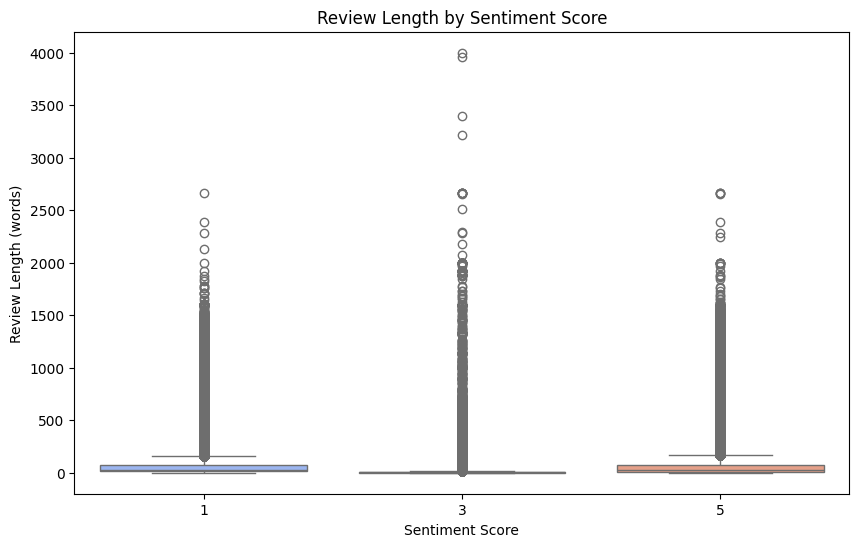

In [7]:
# Calculate review length in words
df_unfiltered['review_length'] = df_unfiltered['text'].apply(lambda x: len(str(x).split()))

# Let us view if review length has any correlation with the sentiment score
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating_sentiment', y='review_length', data=df_unfiltered, palette="coolwarm")
plt.title("Review Length by Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Review Length (words)")
plt.show()


/var/folders/hc/3hpjyr617jx1160ry_5rfq_m0000gn/T/ipykernel_76355/702468136.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_sentiment', y='hours', data=df_unfiltered, palette="coolwarm")


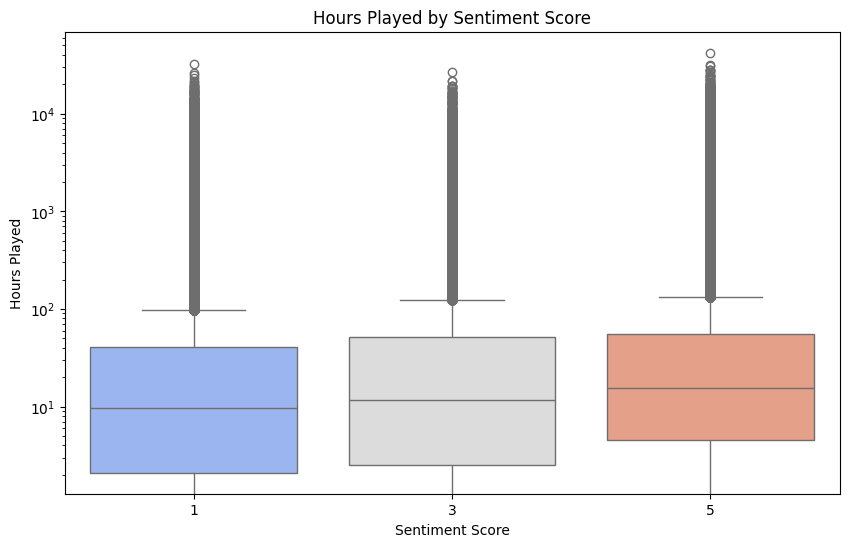

In [ ]:
# Let us see if the hours played has any correlation with the sentiment score

plt.figure(figsize=(10, 6))
sns.boxplot(x='rating_sentiment', y='hours', data=df_unfiltered, palette="coolwarm")
plt.title("Hours Played by Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Hours Played")
plt.yscale("log")
plt.show()

/var/folders/hc/3hpjyr617jx1160ry_5rfq_m0000gn/T/ipykernel_76355/1008370434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='playtime_category', y='rating_sentiment', data=df_unfiltered, estimator=np.mean, palette="coolwarm")


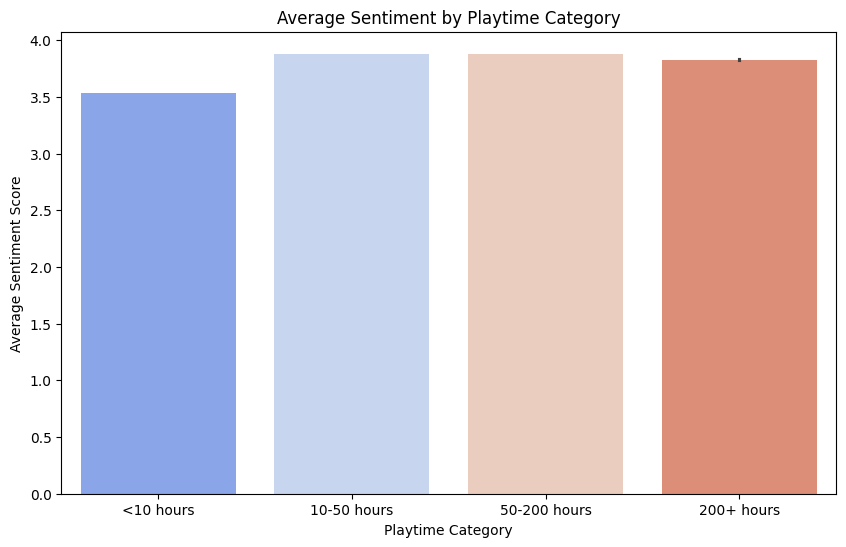

In [11]:
import numpy as np

# Define playtime categories
df_unfiltered['playtime_category'] = pd.cut(df_unfiltered['hours'], bins=[0, 10, 50, 200, float('inf')], labels=['<10 hours', '10-50 hours', '50-200 hours', '200+ hours'])

# Plot average sentiment by playtime category
plt.figure(figsize=(10, 6))
sns.barplot(x='playtime_category', y='rating_sentiment', data=df_unfiltered, estimator=np.mean, palette="coolwarm")
plt.title("Average Sentiment by Playtime Category")
plt.xlabel("Playtime Category")
plt.ylabel("Average Sentiment Score")
plt.show()


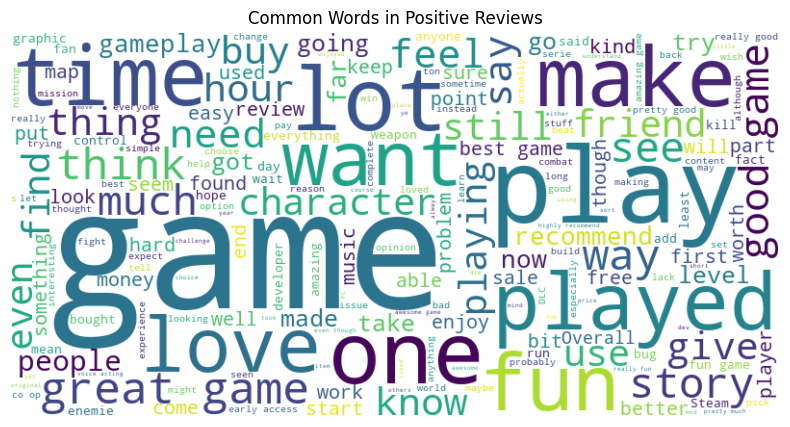

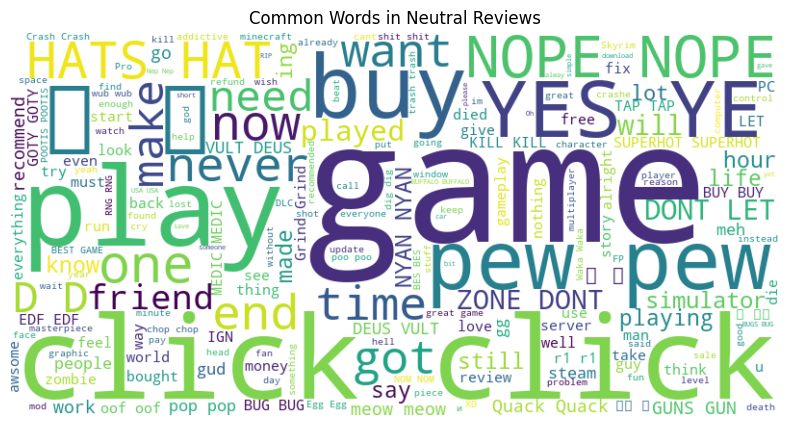

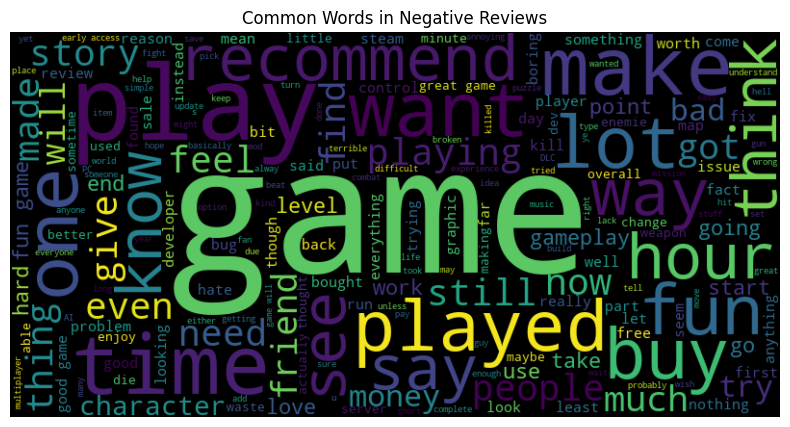

In [10]:
from wordcloud import WordCloud

# Filter positive and negative reviews
positive_reviews = " ".join(df_unfiltered[df_unfiltered['rating_sentiment'] == 5]['text'].dropna().tolist())
negative_reviews = " ".join(df_unfiltered[df_unfiltered['rating_sentiment'] == 1]['text'].dropna().tolist())
neutral_reviews = " ".join(df_unfiltered[df_unfiltered['rating_sentiment'] == 3]['text'].dropna().tolist())

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color="black").generate(negative_reviews)
wordcloud_neutral = WordCloud(width=800, height=400, background_color="white").generate(neutral_reviews)

# Display positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Positive Reviews")
plt.show()

# Display neutral word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Neutral Reviews")
plt.show()

# Display negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Negative Reviews")
plt.show()